In [2]:
import quandl
from sklearn import preprocessing

C:\Users\rosehyr\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\rosehyr\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\rosehyr\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
#df = quandl.get('WIKI/GOOGL')
df = quandl.get('WIKI/AAPL')

In [4]:
import math
import numpy as np

In [5]:
# 定义预测列变量，它存放研究对象的标签名
forecast_col = 'Adj. Close'
# 定义预测天数，这里设置为所有数据量长度的1%
forecast_out = int(math.ceil(0.01*len(df)))
# 只用到df中下面的几个字段
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
# 构造两个新的列
# HL_PCT为股票最高价与最低价的变化百分比
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100.0
# PCT_change为股票收盘价与开盘价的变化百分比
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0
# 下面为真正用到的特征字段
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
# 因为scikit-learn并不会处理空数据，需要把为空的数据都设置为一个比较难出现的值，这里取-9999，
df.fillna(-99999, inplace=True)
# 用label代表该字段，是预测结果
# 通过让与Adj. Close列的数据往前移动1%行来表示
df['label'] = df[forecast_col].shift(-forecast_out)
# 最后生成真正在模型中使用的数据X和y和预测时用到的数据数据X_lately
X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
# 上面生成label列时留下的最后1%行的数据，这些行并没有label数据，因此我们可以拿他们作为预测时用到的输入数据
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# 抛弃label列中为空的那些行
df.dropna(inplace=True)
y = np.array(df['label'])

C:\Users\rosehyr\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [6]:
# scikit-learn从0.2版本开始废弃cross_validation，改用model_selection
from sklearn import  model_selection, svm
from sklearn.linear_model import LinearRegression
# 开始前，先X和y把数据分成两部分，一部分用来训练，一部分用来测试
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)
# 生成scikit-learn的线性回归对象
clf = LinearRegression(n_jobs=-1)

In [7]:
# 开始训练
clf.fit(X_train, y_train)
# 用测试数据评估准确性
accuracy = clf.score(X_test, y_test)

# 进行预测
forecast_set = clf.predict(X_lately)
print(forecast_set, accuracy)

[188.43419842 187.15447948 186.3707221  183.49170637 181.14524534
 183.31111979 182.28653999 182.15331345 185.35964018 187.42032493
 187.47603567 186.53089937 185.35498504 181.42806583 184.08106921
 183.20415525 181.82052491 181.56303644 180.91904617 181.48971515
 181.41701747 184.82974711 183.98509008 184.50519179 184.4947656
 186.31245721 188.89037623 187.00127819 186.77116029 187.39725793
 187.50497294 182.73970526 182.81656031 183.27785984 181.31464593
 184.50386414 184.33163315 185.37830523 187.42297903 186.71334186
 186.77418862 186.73852366 187.79703905 189.70978437 188.54055131
 191.74450239 192.02018288 191.13326987 189.62507015 189.4616267
 186.53562704 183.13305303 183.81470673 179.90967827 178.85283371
 179.31852426 179.7132501  171.44289571 168.09129864 174.12245365
 170.77123907 166.09166691 167.0673543  174.00333137 175.97401846
 179.11314851 185.20893103 184.5149861  183.90825071 183.09050493
 184.78282763 188.03227228 191.59367791 190.97289007 190.65874404
 187.1829205

In [8]:
import matplotlib.pyplot as plt
from matplotlib import style
import datetime

In [9]:
# 修改matplotlib样式
style.use('ggplot')
one_day = 86400
# 在df中新建Forecast列，用于存放预测结果的数据
df['Forecast'] = np.nan
# 取df最后一行的时间索引
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
next_unix = last_unix + one_day
# 遍历预测结果，用它往df追加行
# 这些行除了Forecast字段，其他都设为np.nan
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    # [np.nan for _ in range(len(df.columns) - 1)]生成不包含Forecast字段的列表
    # 而[i]是只包含Forecast值的列表
    # 上述两个列表拼接在一起就组成了新行，按日期追加到df的下面
    df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]


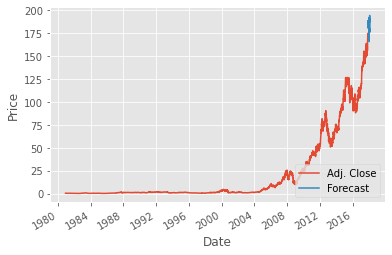

In [10]:
# 开始绘图
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()